# Topics in English Quran

In [1]:
import glob
from collections import defaultdict
import pdb

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from gensim import corpora, models
# from gensim.utils import lemmatize  # not working with PY3.7 due to Pattern package
from wordcloud import WordCloud
import spacy
import pyLDAvis
import pyLDAvis.gensim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 500)

# import nltk
# nltk.download()

## Pre-processing

In [7]:
sura_medina = [2, 3, 4, 5, 8, 9, 22, 24, 33, 47, 48, 49, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 98, 110]
sura_mecca_first = [96, 74, 111, 106, 108, 104, 107, 102, 105, 92,
90, 94, 93, 97, 86, 91, 80, 68, 87, 95,
103, 85, 73, 101, 99, 82, 81, 53, 84, 100,
79, 77, 78, 88, 89, 75, 83, 69, 51, 52,
56, 70, 55, 112, 109, 113, 114, 1]
sura_mecca_second = [54, 37, 71, 76, 44, 50, 20, 26, 15, 19,
38, 36, 43, 72, 67, 23, 21, 25, 17, 27, 18]
sura_mecca_third = [32, 41, 45, 16, 30, 11, 14, 12, 40, 28,
39, 29, 31, 42, 10, 34, 35, 7, 46, 6, 13]
sura_ind = [sura_mecca_first, sura_mecca_second, sura_mecca_third, sura_medina]
ALL_SURAH_INDICES = range(1, 115)

BASMALA = 'in the name of allah, the gracious, the merciful.'

In [95]:
def read_in_quran(suras_indices, data_folder='../data/quran-verse-by-verse-text/'):
    documents = [] 
    i_surah = []
    i_verse = []
    for chapter in suras_indices:
        files = sorted(glob.glob(data_folder + str(chapter).zfill(3) + '*'))
        # Remove non ascii and change to lower case; not necessary with RegexpTokenizer(r'\w+')
        surah = []
        for ind_verse, f in enumerate(files):
            with open(f, 'rb') as hf:
                text = hf.read()
                verse = text.decode('utf-8').encode('ascii', errors='ignore').lower().decode('utf-8')
                surah.append(verse)
                i_surah.append(chapter)
                i_verse.append(ind_verse + 1)
        documents.append(surah)  
    return documents, i_surah, i_verse

def remove_basmala(documents, i_verse=None):
    if isinstance(documents[0], list):  # if the input is by surah (list of list)
        for doc in documents:
            if BASMALA in doc:
                doc.remove(BASMALA)
    else:
        if i_verse is None:
            print('Must provide verse indices for document by verse')
            return None
        for i, _ in enumerate(i_verse):
            if documents[i] == BASMALA:
                del i_verse[i]
                del i_surah[i]
                del documents[i]

def tokenize_docs(docs):
    # removing whitespaces and punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    for document in docs:
        yield(tokenizer.tokenize(document))

def remove_stopwords(docs, additional_stops=None):
    stop = stopwords.words('english')
    if additional_stops is not None:
        stop = stop + additional_stops 
    return [[word for word in doc if word not in stop] for doc in docs]

def lemmatization(docs, is_stemming=False):
    stem_map = defaultdict(set)
    parsed_docs = []
    if is_stemming:  # do stemming
        stemmer = PorterStemmer()
        for doc in docs:
            parsed_doc = []
            for word in doc:
                stemmed = stemmer.stem(word)
                parsed_doc.append(stemmed)
                stem_map[stemmed].add(wod)
            parsed_docs.append(parsed_doc)
    else:  # do lemmatization with stacy
        # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
#         nlp = en_core_web_sm.load(disable=['parser', 'ner'])
        # Extract the lemma for each token and join
        for doc in docs:
            nlp_parsed = nlp(' '.join(doc))
            parsed_doc = []
            for word in nlp_parsed: 
                lemma = word.lemma_
                parsed_doc.append(lemma)
                stem_map[lemma].add(word.text)
            parsed_docs.append(parsed_doc)
    return parsed_docs, stem_map

def parse_docs(docs, is_stop=True, additional_stops=None, is_stemming=False):
    intermediates = list(tokenize_docs(docs))
    if is_stop:
        intermediates = remove_stopwords(intermediates, additional_stops)
    processed, stem_map = lemmatization(intermediates, is_stemming)
    return intermediates, processed, stem_map

def word_cloud(corpus):
    def get_word_cloud(input_text):
        # Read the whole text.
        text = ' '.join(input_text)
        # lower max_font_size
        return WordCloud(max_font_size=60).generate(text)
        
    if isinstance(corpus[0], list):        
        n = len(corpus)
        f, a = plt.subplots(nrows=n, figsize=(8, n * 6))
        for i, input_text in enumerate(corpus):
            wordcloud = get_word_cloud(input_text)
            a[i].imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        wordcloud = get_word_cloud(corpus)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

### Read in and decode

In [9]:
### Downloaded at http://www.clearquran.com/
suras_indices = ALL_SURAH_INDICES  # [optional] choose surahs in certain periods
documents_by_surah_as_list, i_surah, i_verse = read_in_quran(suras_indices, data_folder='../data/quran-verse-by-verse-text/')
documents_by_verse = [verse for surah in documents_by_surah_as_list for verse in surah]

remove_basmala(documents_by_verse, i_verse)
remove_basmala(documents_by_surah_as_list)

documents_by_surah = [' '.join(surah) for surah in documents_by_surah_as_list]

df0 = pd.DataFrame({'text': documents_by_verse, 'surah': i_surah, 'verse': i_verse})

### Parsing 

In [49]:
is_by_verse = True
docs = documents_by_verse if is_by_verse else documents_by_surah
additional_stops = None #['god', 'lord']
tokens, processed, stem_map = parse_docs(docs, is_stop=True, additional_stops=additional_stops)

## Some EDA

### Word freq

In [11]:
df = pd.Series([jj for ii in processed for jj in ii])

df.value_counts()[:4]

allah     2418
say       1587
lord       965
people     683
dtype: int64

In [12]:
# check some verses 
# count = 0
# for ii, jj in enumerate(tokens):    
#     if 'day' in jj:
#         count += 1
#         print(ii, docs[ii])
#         if count > 2:
#             break

### get ngram

In [13]:
num_grams = 3
input_corpus = processed
ngrams_by_verse = [list(ngrams(token, num_grams)) for token in input_corpus]

In [14]:
all_ngrams = []
ind_surah = []
ind_verse = []
for i, j in enumerate(ngrams_by_verse):
    for g in j:
        ind_surah.append(i_surah[i])
        ind_verse.append(i_verse[i])
        all_ngrams.append(g)

In [15]:
dfng = pd.DataFrame({'value': all_ngrams, 'surah': ind_surah, 'verse': ind_verse})

In [16]:
dfng_j = pd.merge(dfng, df0, on=['surah', 'verse'])

In [17]:
dfng_j['value'].value_counts()[:10]

(allah, forgiving, merciful)    35
(lord, marvel, deny)            32
(create, heavens, earth)        31
(beneath, river, flow)          30
(allah, last, day)              23
(garden, beneath, river)        23
(believe, allah, last)          20
(believe, good, deed)           19
(give, good, news)              16
(believe, righteous, deed)      15
Name: value, dtype: int64

In [18]:
dfng_j[dfng_j['value'] == dfng_j['value'].value_counts().index[0]][:4]

,value,surah,verse,text
1850,"(allah, forgiving, merciful)",2,174,"he has forbidden you carrion, and blood, and the flesh of swine, and what was dedicated to other than allah. but if anyone is compelled, without desiring or exceeding, he commits no sin. allah is forgiving and merciful."
1979,"(allah, forgiving, merciful)",2,183,"should someone suspect bias or injustice on the part of a testator, and then reconciles between them, he commits no sin. allah is forgiving and merciful."
2141,"(allah, forgiving, merciful)",2,193,"but if they cease, then allah is forgiving and merciful."
2267,"(allah, forgiving, merciful)",2,200,"then disperse from where the people disperse, and ask allah for forgiveness. allah is most forgiving, most merciful."


## Embedding and similarity 

In [19]:
import gensim.models as w2v
model = w2v.Word2Vec(sentences=processed, size=100, window=7, min_count=15, sg=0, alpha=0.22, workers=8)
# model.save('./tokens_CBOW.model')

In [20]:
wv = model.wv

In [29]:
wv.most_similar("aaron", topn=5)

[('inspire', 0.6575703620910645),
 ('solomon', 0.6262310743331909),
 ('recall', 0.5951386094093323),
 ('noah', 0.585008442401886),
 ('moses', 0.5820443630218506)]

In [38]:
from sklearn.decomposition import PCA
words = df.value_counts()[:400].index.values
X = np.array([wv[w] for w in words])

pca = PCA(n_components=10)
result = pca.fit_transform(X)


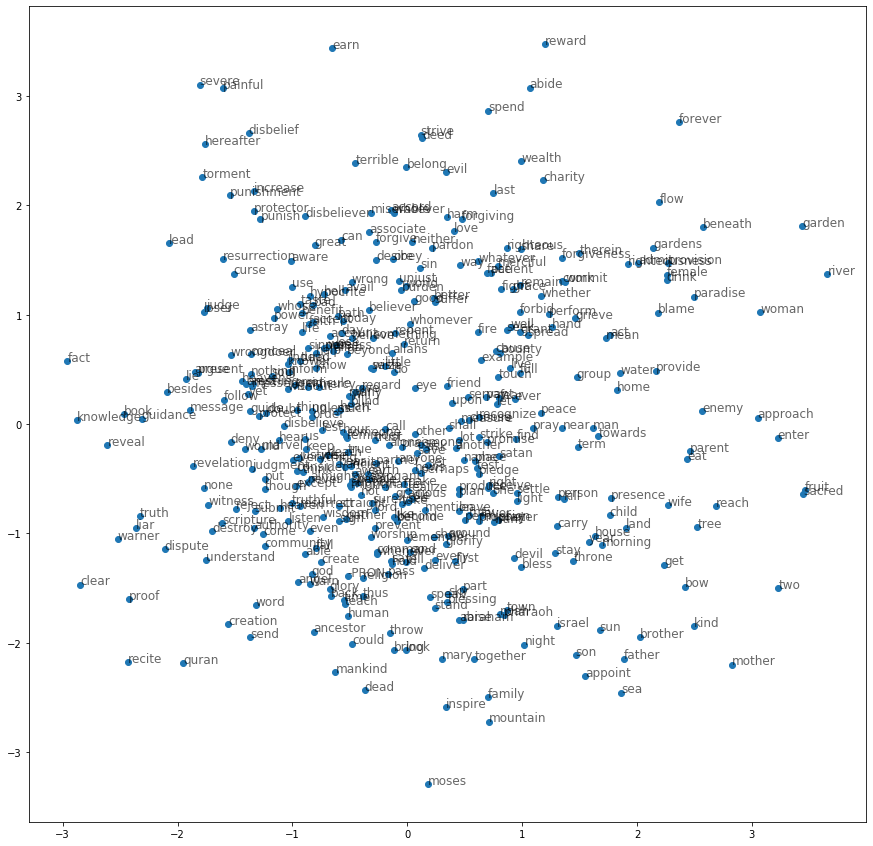

In [44]:
# create a scatter plot of the projection
f, a = plt.subplots(figsize=(15, 15))
a.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    a.annotate(word, xy=(result[i, 0], result[i, 1]), alpha=0.6, fontsize=12)
# a.set_xlim([0, 3]); a.set_ylim([0, 3])
plt.show()

## Topics

### Parse by surah

In [56]:
if is_by_verse:
    df0['processed'] = processed
    processed_by_surah = df0.groupby('surah')['processed'].apply(sum).values.tolist()
else: 
    processed_by_surah = processed

# remove '-PRON-'
processed_by_surah = [list(filter(lambda a: a != '-PRON-', i)) for i in processed_by_surah]

### Making dictionary and corpus

In [57]:
# making dictionary and corpus
dictionary = corpora.Dictionary(processed_by_surah)
corpus = [dictionary.doc2bow(text) for text in processed_by_surah]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
# Save
#dictionary.save('/tmp/dict.dict')
#corpora.MmCorpus.serialize('/tmp/temp.mm', corpus)

### TFIDF

In [59]:
item_document_fre = dictionary.dfs
for k in dictionary.keys()[:4]:
    print(k, dictionary[k], item_document_fre[k])

0 allah 82
1 anger 4
2 bless 29
3 call 53


In [60]:
# Compare bow and tiidf
i = 0
print(processed_by_surah[i], '\n',
      [dictionary[k[0]] for k in corpus[i]], '\n',
      corpus[i], '\n', 
      corpus_tfidf[i])

['praise', 'allah', 'lord', 'world', 'gracious', 'merciful', 'master', 'day', 'judgment', 'worship', 'upon', 'call', 'help', 'guide', 'straight', 'path', 'path', 'bless', 'anger', 'misguide'] 
 ['allah', 'anger', 'bless', 'call', 'day', 'gracious', 'guide', 'help', 'judgment', 'lord', 'master', 'merciful', 'misguide', 'path', 'praise', 'straight', 'upon', 'world', 'worship'] 
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)] 
 [(0, 0.04845352024773868), (1, 0.492640036044582), (2, 0.2013121025870043), (3, 0.11263493315072866), (4, 0.043169325280030334), (5, 0.2982613828990869), (6, 0.10193487428861422), (7, 0.18683541317873928), (8, 0.24193818317734606), (9, 0.028368594012498187), (10, 0.2982613828990869), (11, 0.13669842963590823), (12, 0.43301195707001744), (13, 0.2936891720131065), (14, 0.14684458600655326), (15, 0.2231388877027208), (16, 0.07816374556897575), (17, 0.1695

### LDA

In [61]:
# LDA modeling
NUM_TOPICS = 4
NUM_WORDS = 10

corpus_input = corpus_tfidf

lda = models.LdaModel(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, passes=10)
corpus_lda = lda[corpus_input] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi
topics = lda.print_topics(num_topics=-1, num_words=NUM_WORDS)

In [62]:
print('Perplexity: ', lda.log_perplexity(corpus_input))
coherence_model_lda = models.CoherenceModel(
    model=lda, texts=processed_by_surah, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -10.018536799599458

Coherence Score:  0.44381074421267724


### Hyperparameter optimization

In [67]:
num_topics_list = range(5, 40, 4)
lda_models = []
coherence_scores = []
for NUM_TOPICS in num_topics_list:
    lda = models.LdaModel(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, passes=10)
    coherence_model_lda = models.CoherenceModel(
        model=lda, texts=processed_by_surah, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    lda_models.append(lda)
    coherence_scores.append(coherence_lda)

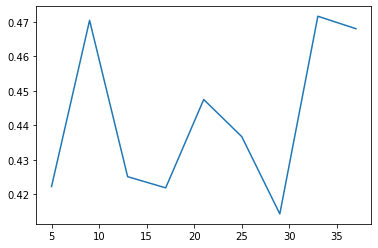

In [68]:
plt.plot(num_topics_list, coherence_scores)

### Results

#### Visualize

In [63]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus_input, dictionary)
vis

c:\users\yuwei\tools\env\penv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.025955 -0.000007       1        1  91.183624
3     -0.009129 -0.001424       2        1   3.081463
0     -0.007810  0.000056       3        1   2.943740
1     -0.009015  0.001375       4        1   2.791177, topic_info=     Category      Freq          Term     Total  loglift  logprob
399   Default  0.000000          evil  0.000000  30.0000  30.0000
1028  Default  0.000000         serve  0.000000  29.0000  29.0000
373   Default  0.000000          ease  0.000000  28.0000  28.0000
698   Default  0.000000       mankind  0.000000  27.0000  27.0000
3037  Default  0.000000        marvel  0.000000  26.0000  26.0000
18    Default  1.000000       worship  1.000000  25.0000  25.0000
793   Default  0.000000        orphan  0.000000  24.0000  24.0000
897   Default  0.000000         raise  0.000000  23.0000  23.0000
1278  Default  0.000000           woe  0.000000  22.0000  22.0000
934   Default  0.000000      religion  0.000000  21.0000  21.0000
279   Default  0.000000        decree  0.000000  20.0000  20.0000
348   Default  0.000000            do  0.000000  19.0000  19.0000
534   Default  0.000000      hardship  0.000000  18.0000  18.0000
91    Default  0.000000        around  0.000000  17.0000  17.0000
1283  Default  0.000000          work  0.000000  16.0000  16.0000
1244  Default  0.000000        wealth  0.000000  15.0000  15.0000
295   Default  0.000000          deny  0.000000  14.0000  14.0000
1591  Default  0.000000        refuge  0.000000  13.0000  13.0000
811   Default  0.000000      patience  0.000000  12.0000  12.0000
1019  Default  0.000000      security  0.000000  11.0000  11.0000
757   Default  0.000000         night  0.000000  10.0000  10.0000
903   Default  0.000000          read  0.000000   9.0000   9.0000
1860  Default  0.000000           low  0.000000   8.0000   8.0000
854   Default  0.000000        prayer  0.000000   7.0000   7.0000
1826  Default  0.000000         human  0.000000   6.0000   6.0000
1241  Default  0.000000           way  0.000000   5.0000   5.0000
493   Default  0.000000        gather  0.000000   4.0000   4.0000
1671  Default  0.000000      withhold  0.000000   3.0000   3.0000
1705  Default  0.000000          atom  0.000000   2.0000   2.0000
102   Default  0.000000         avail  0.000000   1.0000   1.0000
0      Topic1  4.660650         allah  4.686870   0.0867  -5.5612
1005   Topic1  3.219616           say  3.245544   0.0843  -5.9311
817    Topic1  1.950102        people  1.974862   0.0797  -6.4325
126    Topic1  1.607835       believe  1.631701   0.0776  -6.6255
718    Topic1  1.439382     messenger  1.462787   0.0762  -6.7361
784    Topic1  1.386206           one  1.410545   0.0749  -6.7738
708    Topic1  1.273649           may  1.296579   0.0745  -6.8585
694    Topic1  1.302731          make  1.326298   0.0744  -6.8359
1287   Topic1  1.303162         would  1.326791   0.0743  -6.8356
9      Topic1  1.439894          lord  1.466017   0.0743  -6.7358
497    Topic1  1.273887          give  1.297622   0.0738  -6.8583
208    Topic1  1.311177          come  1.336158   0.0734  -6.8294
54     Topic1  1.272542        allahs  1.296843   0.0734  -6.8593
506    Topic1  1.252830          good  1.276940   0.0732  -6.8749
4      Topic1  1.305133           day  1.331292   0.0725  -6.8340
1049   Topic1  1.097088          sign  1.119630   0.0720  -7.0077
68     Topic1  1.136432         among  1.159884   0.0719  -6.9725
372    Topic1  1.118088         earth  1.141257   0.0718  -6.9887
323    Topic1  1.091908    disbelieve  1.114831   0.0715  -7.0124
1024   Topic1  1.096846          send  1.120073   0.0713  -7.0079
1020   Topic1  1.146137           see  1.170679   0.0711  -6.9640
886    Topic1  1.063661    punishment  1.086805   0.0708  -7.0386
737    Topic1  1.018744         moses  1.040973   0.0707  -7.0818
16     Topic1  1.065859          upon  1.089200   0.0706  -7.0366
128

#### Check individual surah

In [55]:
# Get score for individual verse
i = 107
print(processed_by_surah[i])
sorted_rel = sorted(corpus_lda[i], key=lambda x: x[1], reverse=True)
print('Top 3 topics of this doc: \n', sorted_rel[:3])
print('First topic: \n', topics[sorted_rel[0][0]])
print('2nd topic: \n', topics[sorted_rel[1][0]])

['give', 'plenty', 'pray', 'lord', 'sacrifice', 'hate', 'loser']
Top 3 topics of this doc: 
 [(8, 0.67453676), (0, 0.039695486), (1, 0.015875984)]
First topic: 
 (8, '0.003*"encourage" + 0.002*"plenty" + 0.002*"sacrifice" + 0.002*"recommend" + 0.002*"hate" + 0.002*"considered" + 0.002*"assistance" + 0.002*"feeding" + 0.001*"loss" + 0.001*"appearance"')
2nd topic: 
 (0, '0.010*"allah" + 0.007*"say" + 0.004*"people" + 0.003*"believe" + 0.003*"lord" + 0.003*"messenger" + 0.003*"one" + 0.003*"day" + 0.003*"come" + 0.003*"would"')


#### Dominant topics for each surah

In [69]:
ind_max_topic = [max(i, key=lambda x: x[1])[0] for i in corpus_lda]

#### WordCloud

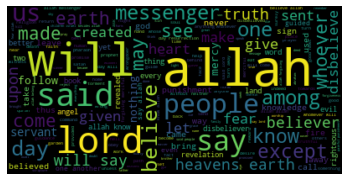

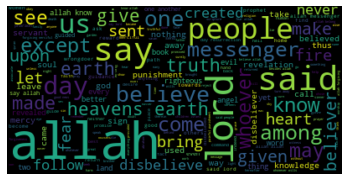

In [99]:
word_cloud(docs)
# after parsing
word_cloud([' '.join(ii) for ii in tokens])

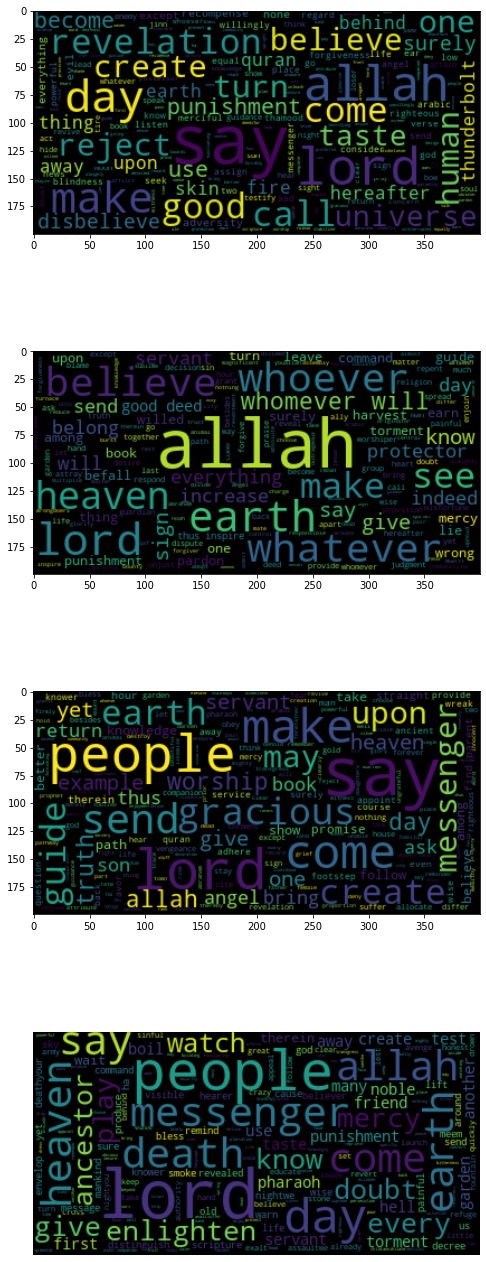

In [101]:
word_cloud(processed_by_surah[40:44])